### K-Means clustering for image quantization and segmentation
#### Aimee Nogoy

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

<b><i>Import packages and load image</i></b>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
% matplotlib inline
import cv2

In [3]:
# import the sklearn stuff
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from sklearn.metrics import pairwise_distances_argmin
from time import time

In [4]:
# ramen = cv2.imread('ramen.jpg', 1)
ramen = cv2.imread('sagrada2.jpg', 1)
ramen = cv2.cvtColor(ramen, cv2.COLOR_RGB2BGR)

### 1. Image Color Quantization Using K-means Algorithm

In [5]:
def recreate_image(codebook, labels, w, h):
    # Recreate the compressed image (bc quantizing colors) from the codebook and labels
    d = codebook.shape[1]
#     print(codebook.shape)
    image =  np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [6]:
# K-means color quant function
def color_quant(K, img):
    img = np.array(img, dtype=np.float) / 255
    
#     transform image to 2d array
    w, h, d = original_shape = tuple(img.shape)
    assert d == 3
    image_array = np.reshape(img, (w * h, d))
    
#     fit model on small sub-sample of data
    t0 = time()
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters = K, random_state = 0).fit(image_array_sample)
    print('done in %0.3fs.' % (time() - t0))
    
#     now get labels for all the points
    print('Predicting color indices on the full image with k-means')
    t0 = time()
    labels = kmeans.predict(image_array)
    print('done in %0.3fs.' % (time() - t0))
    
    imgq = recreate_image(kmeans.cluster_centers_, labels, w, h)
    
#     benchmark algo
    codebook_random = shuffle(image_array, random_state=0)[:K + 1]
    print('Predicting color indices on the full image (random)')
    t0 = time()
    labels_random = pairwise_distances_argmin(codebook_random, image_array, axis = 0)
    print('done in %0.3fs' % (time() - t0))
    
#     benchmark algo image result
    imgqr = recreate_image(codebook_random, labels_random, w, h)
    
    return imgq, imgqr

In [7]:
# for K = 256
K = 256
ramen256, ramen256r = color_quant(K, ramen)

done in 1.758s.
Predicting color indices on the full image with k-means
done in 0.104s.
Predicting color indices on the full image (random)
done in 0.108s


In [8]:
# for K = 64
K = 64
ramen64, ramen64r = color_quant(K, ramen) # nintendo 64 ayyyy

done in 0.428s.
Predicting color indices on the full image with k-means
done in 0.026s.
Predicting color indices on the full image (random)
done in 0.026s


(-0.5, 219.5, 164.5, -0.5)

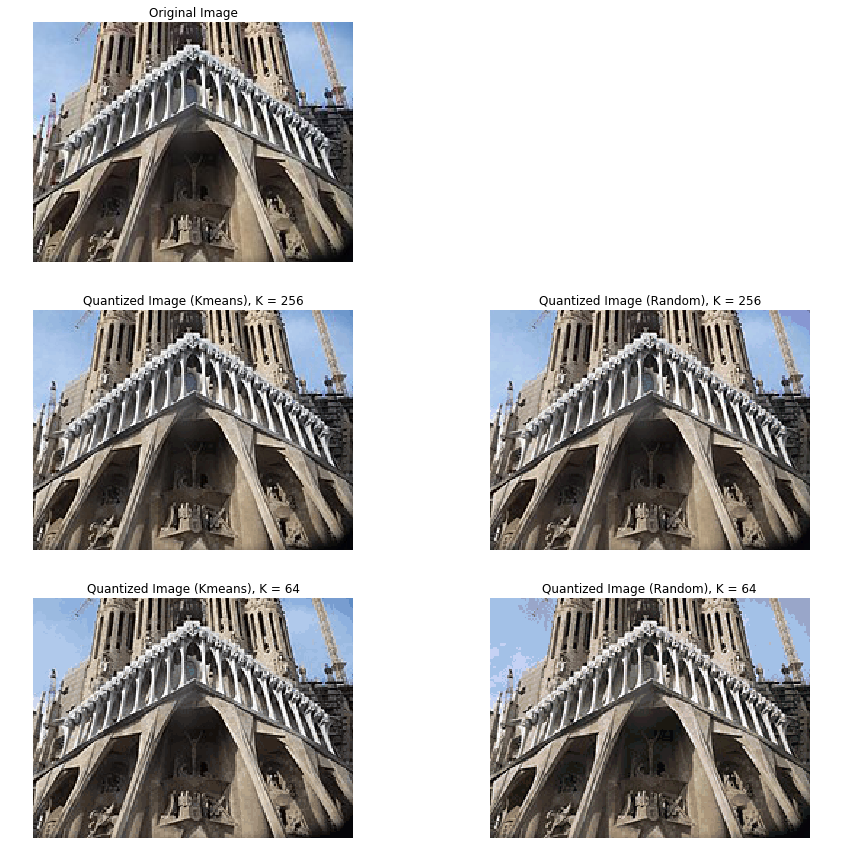

In [9]:
fig, [[ax1, ax2],[ax3, ax4],[ax5, ax6]] = plt.subplots(3, 2, figsize = [15, 15])

ax1.imshow(ramen); ax1.set_title('Original Image');
ax1.axis('off')

ax2.axis('off')

ax3.imshow(ramen256); ax3.set_title('Quantized Image (Kmeans), K = 256');
ax3.axis('off')

ax4.imshow(ramen256r); ax4.set_title('Quantized Image (Random), K = 256');
ax4.axis('off')

ax5.imshow(ramen64); ax5.set_title('Quantized Image (Kmeans), K = 64');
ax5.axis('off')

ax6.imshow(ramen64r); ax6.set_title('Quantized Image (Random), K = 64')
ax6.axis('off')

#### Comments

As opposed to the K = 256, K = 64 clusters shows some artifacts in the background of the picture. Despite this, all the quantized images -- both k-means and random -- look quite similar to the original.

#### Now modify the initialization process
<p>I used `init = 'k-means++'` and `n_init = 1` as suggested in the problem statement.

In [10]:
# K-means color quant function
def color_quant2(K, img, state):
    img = np.array(img, dtype=np.float) / 255
    
#     transform image to 2d array
    w, h, d = original_shape = tuple(img.shape)
    assert d == 3
    image_array = np.reshape(img, (w * h, d))
    
#     fit model on small sub-sample of data
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters = K, init = 'k-means++', n_init = 1, verbose = True, random_state = state)
    kmeans.fit(image_array_sample)
    
#     now get labels for all the points
    print('\nPredicting color indices on the full image with k-means: %s\n\n' % kmeans)
    t0 = time()
    labels = kmeans.predict(image_array)
    print('done in %0.3fs.' % (time() - t0))
    
    imgq = recreate_image(kmeans.cluster_centers_, labels, w, h)
    
    return imgq

In [11]:
K = 64
shiz = color_quant2(K, ramen, 40)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 0.793428383485
start iteration
done sorting
end inner loop
Iteration 1, inertia 0.748682510398
start iteration
done sorting
end inner loop
Iteration 2, inertia 0.737219331849
start iteration
done sorting
end inner loop
Iteration 3, inertia 0.729795561133
start iteration
done sorting
end inner loop
Iteration 4, inertia 0.726119322964
start iteration
done sorting
end inner loop
Iteration 5, inertia 0.724676415923
start iteration
done sorting
end inner loop
Iteration 6, inertia 0.723889996329
start iteration
done sorting
end inner loop
Iteration 7, inertia 0.723785421992
center shift 2.385454e-03 within tolerance 7.322033e-06

Predicting color indices on the full image with k-means: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=64, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=40, tol=0.0001, verbose=True)


done in 0.041s.


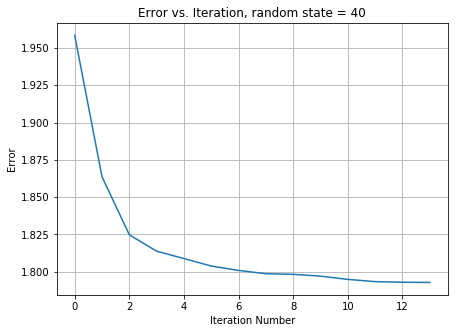

In [12]:
# the dumb way
iternum = np.arange(0,14)
inertia = np.array([1.95848257178, 1.86365142483, 1.82471659175, 1.81373388642, 1.80880714942, \
                    1.80376587144, 1.80084284026, 1.79863442532, 1.79821427026,  1.7970243085, \
                    1.7948180556, 1.79332429781, 1.79292804423, 1.7927822103])

plt.figure(1, figsize=(7,5));
plt.plot(iternum, inertia); plt.grid(1)
plt.title('Error vs. Iteration, random state = 40');
plt.ylabel('Error'); plt.xlabel('Iteration Number')


In [13]:
shiz2 = color_quant2(64, ramen, 5)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 0.786823397955
start iteration
done sorting
end inner loop
Iteration 1, inertia 0.745878350265
start iteration
done sorting
end inner loop
Iteration 2, inertia 0.730710146088
start iteration
done sorting
end inner loop
Iteration 3, inertia 0.723757940916
start iteration
done sorting
end inner loop
Iteration 4, inertia 0.719258741821
start iteration
done sorting
end inner loop
Iteration 5, inertia 0.717500258941
start iteration
done sorting
end inner loop
Iteration 6, inertia 0.715787066549
start iteration
done sorting
end inner loop
Iteration 7, inertia 0.713222343973
start iteration
done sorting
end inner loop
Iteration 8, inertia 0.711755014559
start iteration
done sorting
end inner loop
Iteration 9, inertia 0.71109802671
start iteration
done sorting
end inner loop
Iteration 10, inertia 0.710679735347
start iteration
done sorting
end inner loop
Iteration 11, inertia 0.71060472179
center shift 1.7

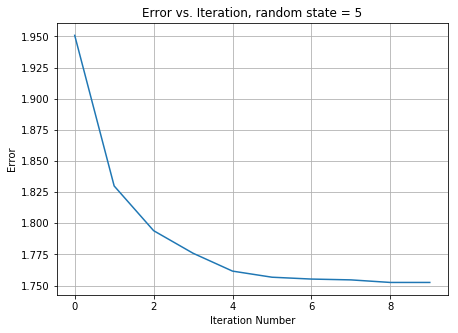

In [14]:
iternum = np.arange(0,10)
inertia = np.array([1.95087781123, 1.82993235592, 1.79403959066, 1.77589929943, \
                   1.76155643506, 1.75665761635, 1.75516765725, 1.75451429549, \
                   1.75245541371, 1.75245541371])

plt.figure(1, figsize=(7,5));
plt.plot(iternum, inertia); plt.grid(1)
plt.title('Error vs. Iteration, random state = 5');
plt.ylabel('Error'); plt.xlabel('Iteration Number')


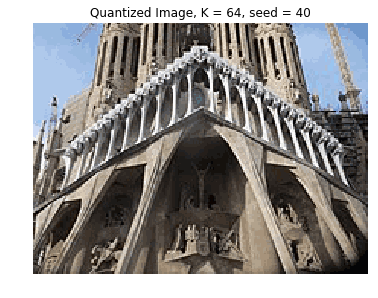

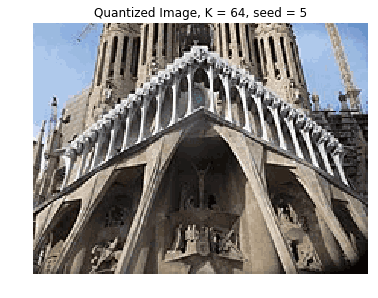

In [15]:
# display pix
plt.figure(1, figsize=(6,6));
plt.imshow(shiz); plt.axis('off'); 
plt.title('Quantized Image, K = 64, seed = 40')

plt.figure(2, figsize=(6,6));
plt.imshow(shiz2); plt.axis('off');
plt.title('Quantized Image, K = 64, seed = 5')

** Comments **
<p>The error curves for each random state (40 and 5) are of similar shape but not entirely the same--number of iterations and each inertia were different for the different seeds. In terms of the quantized images, they look very similar. So for this particular image and for K = 64, the seed of the random number generator doesn't significantly affect the color quantization quality, as in the quantization stays true to the original image I think.

### 2. Image Segmentation 
<p>**considering both color homogeneity and region connectivity **

Modify function to include both color and pixel coordinate--> the feature vector of each pixel that will be used in Kmeans.fit() for the codebook cookbook and Kmeans.predict() to find the label of each pixel

In [16]:
# Modify recreate image function a bit
def recreate_image2(codebook, labels, w, h):
    # Recreate the compressed image (bc quantizing colors) from the codebook and labels
    codebook = codebook[:, 2:5] # bc codebook includes all 5 features. 
#     only using the color information
    d = codebook.shape[1]
    image =  np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [17]:

# Modifiy K-means color quant function for image segmentation
def img_seg(K, img, wt):
#     img = np.array(img, dtype=np.float) / 255 # do I need this line?
    
#     transform image to 2d array
    w, h, d = original_shape = tuple(img.shape)
    
    x = []
    y = []
    r = []
    g = []
    b = []

    height = img.shape[0]
    width = img.shape[1]
    nrows = np.arange(height)
    ncols = np.arange(width)

    for i in nrows:
        for j in ncols:
            x.append(i)
            y.append(j)
            b.append(img[i,j,0])
            g.append(img[i,j,1])
            r.append(img[i,j,2])

    x = np.array(x)
    y = np.array(y)
    b = np.array(b)
    g = np.array(g)
    r = np.array(r)

    # add weights to position data
    x2 = (x / height) * 255 * wt
    y2 = (y / width) * 255 * wt

    features = np.vstack([x2,y2,b,g,r]).T
    
#     fit model on small sub-sample of data
    t0 = time()
    image_array_sample = shuffle(features, random_state=0)[:1000]
    kmeans = KMeans(n_clusters = K, random_state = 0, verbose = True).fit(image_array_sample)
    print('done in %0.3fs.' % (time() - t0))
    
#     now get labels for all the points
    print('Predicting color indices on the full image with k-means')
    t0 = time()
    labels = kmeans.predict(features)
    print('\ndone in %0.3fs.' % (time() - t0))
    
    imgq = recreate_image2(kmeans.cluster_centers_, labels, w, h)
    
    return imgq

The parameter `K = 64` is used for the next three trials, with a variable weight `wt = 0.25, 0.5, 1` for each pixel location.

In [18]:
K = 64
wt = 0.25
ramens1 = img_seg(K, ramen, wt)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 252799.944986
start iteration
done sorting
end inner loop
Iteration 1, inertia 240987.816522
start iteration
done sorting
end inner loop
Iteration 2, inertia 236433.186939
start iteration
done sorting
end inner loop
Iteration 3, inertia 234774.492899
start iteration
done sorting
end inner loop
Iteration 4, inertia 234327.32783
start iteration
done sorting
end inner loop
Iteration 5, inertia 233656.452229
start iteration
done sorting
end inner loop
Iteration 6, inertia 233082.364563
start iteration
done sorting
end inner loop
Iteration 7, inertia 232915.536492
start iteration
done sorting
end inner loop
Iteration 8, inertia 232804.518422
start iteration
done sorting
end inner loop
Iteration 9, inertia 232804.518422
center shift 0.000000e+00 within tolerance 2.998691e-01
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 258735.466347
start iteration
done sorting

In [19]:
wt = 0.5
ramens2 = img_seg(K, ramen, wt)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 504808.822313
start iteration
done sorting
end inner loop
Iteration 1, inertia 477448.895631
start iteration
done sorting
end inner loop
Iteration 2, inertia 470285.376374
start iteration
done sorting
end inner loop
Iteration 3, inertia 466851.964845
start iteration
done sorting
end inner loop
Iteration 4, inertia 465557.007672
start iteration
done sorting
end inner loop
Iteration 5, inertia 464234.583277
start iteration
done sorting
end inner loop
Iteration 6, inertia 463741.807299
start iteration
done sorting
end inner loop
Iteration 7, inertia 463741.807299
center shift 0.000000e+00 within tolerance 3.424688e-01
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 510411.697318
start iteration
done sorting
end inner loop
Iteration 1, inertia 479030.981904
start iteration
done sorting
end inner loop
Iteration 2, inertia 464873.977344
start iteration
done sortin

In [20]:
wt = 1
ramens3 = img_seg(K, ramen, wt)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 1118696.4231
start iteration
done sorting
end inner loop
Iteration 1, inertia 1024438.45169
start iteration
done sorting
end inner loop
Iteration 2, inertia 996603.152875
start iteration
done sorting
end inner loop
Iteration 3, inertia 983286.119629
start iteration
done sorting
end inner loop
Iteration 4, inertia 978380.40135
start iteration
done sorting
end inner loop
Iteration 5, inertia 970499.049404
start iteration
done sorting
end inner loop
Iteration 6, inertia 963837.166068
start iteration
done sorting
end inner loop
Iteration 7, inertia 957521.937649
start iteration
done sorting
end inner loop
Iteration 8, inertia 956772.545078
start iteration
done sorting
end inner loop
Iteration 9, inertia 956772.545078
center shift 0.000000e+00 within tolerance 5.128679e-01
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 1116274.30311
start iteration
done sorting


(-0.5, 219.5, 164.5, -0.5)

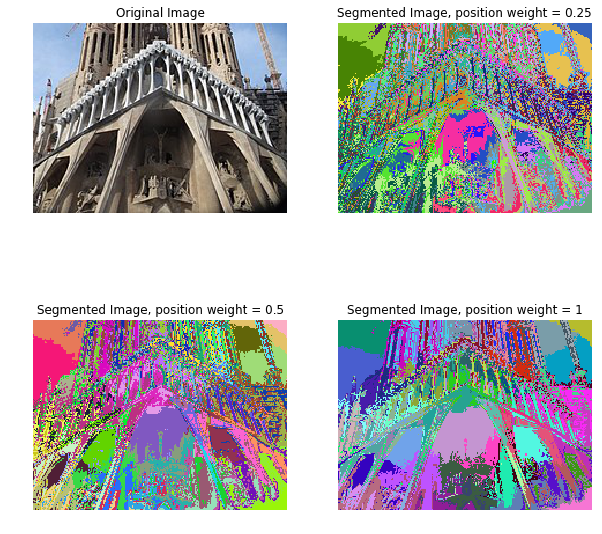

In [21]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2, 2, figsize = [10, 10])

ax1.imshow(ramen); ax1.set_title('Original Image');
ax1.axis('off')

ax2.imshow(ramens1); ax2.set_title('Segmented Image, position weight = 0.25');
ax2.axis('off')

ax3.imshow(ramens2); ax3.set_title('Segmented Image, position weight = 0.5');
ax3.axis('off')

ax4.imshow(ramens3); ax4.set_title('Segmented Image, position weight = 1');
ax4.axis('off')

** Error Curves **
<p> Based on the best initialization in terms of inertia. Data and plots are also in accompanying Excel spreadsheet.

<img src = "error_curve_1.jpg" width = "300" height = "300">
<br><img src = "error_curve_2.jpg" width = "300" height = "300">
<br><img src = "error_curve_3.jpg" width = "300" height = "300">

#### Comments

As seen in the error curves, they follow a similar shape -- always decreasing with each iteration. As w increases, the segmented image shows more regional connectivity, which makes sense due to the increasing weight on the point locations. 

In [118]:
plt.show()